In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize':(11, 4)})


In [3]:
df = pd.read_csv('0.data/forecasting_exercise.csv').rename(columns = {'Unnamed: 0':'id'})

In [4]:
from sklearn import metrics

In [5]:
df.shape

(21922, 6)

In [7]:
df.start = pd.to_datetime(df.start)
df.end = pd.to_datetime(df.end)


In [9]:
df.start.min(), df.start.max()

(Timestamp('2015-11-15 10:10:07'), Timestamp('2016-01-13 23:21:19'))

In [10]:
df.end.min(), df.end.max()

(Timestamp('2015-11-15 10:36:03'), Timestamp('2016-01-14 10:32:24'))

# Convert data to time-series friendly

In [12]:
a = [pd.date_range(*r, freq='H') for r in df[['start', 'end']].values]

df_per_month = (df[['driver_id','num_trips']]
     .join(pd.DataFrame(a))
     .set_index(['driver_id','num_trips'])
     .stack().droplevel(-1).reset_index()).rename(columns={0:'hour'})

In [13]:
df_per_month[df_per_month.driver_id==30859752].head()

,driver_id,num_trips,hour
0,30859752,1,2015-11-15 10:10:07
1,30859752,1,2015-11-15 11:10:07
2,30859752,1,2015-11-15 12:10:07
3,30859752,1,2015-11-15 13:10:07
4,30859752,1,2015-11-15 14:10:07


In [14]:
df_daily = df_per_month.groupby(pd.Grouper(key='hour', freq='D')).agg({'num_trips':'sum',
                                                                      'driver_id':pd.Series.nunique})
df_hourly = df_per_month.groupby(pd.Grouper(key='hour', freq='H')).agg({'num_trips':'sum',
                                 'driver_id':pd.Series.nunique})

# Simple linear model

In [117]:
holidays = ['2015-11-26','2015-11-27','2015-12-24','2015-12-25','2016-01-01']

In [118]:
df_for_ln = df_hourly.copy()

In [119]:
df_for_ln.tail()

,num_trips,driver_id
hour,,
2016-01-14 06:00:00,8,3
2016-01-14 07:00:00,5,1
2016-01-14 08:00:00,5,1
2016-01-14 09:00:00,5,1
2016-01-14 10:00:00,5,1


In [120]:
df_for_ln['week_of_day'] = df_for_ln.index.dayofweek
df_for_ln['weekend'] = 0
df_for_ln.loc[df_for_ln['week_of_day'].isin([5,6]),'weekend'] = 1
df_for_ln['hour_of_day'] = df_for_ln.index.hour
df_for_ln['peak_hour'] = 0
df_for_ln.loc[(df_for_ln['hour_of_day']>8) & (df_for_ln['hour_of_day']<15),'peak_hour'] = 1
df_for_ln['holiday'] = 0
df_for_ln.loc[pd.DatetimeIndex(df_for_ln.index.date).isin(holidays),'holiday'] = 1
df_for_ln = df_for_ln.rename(columns = {'driver_id':'num_drivers'})

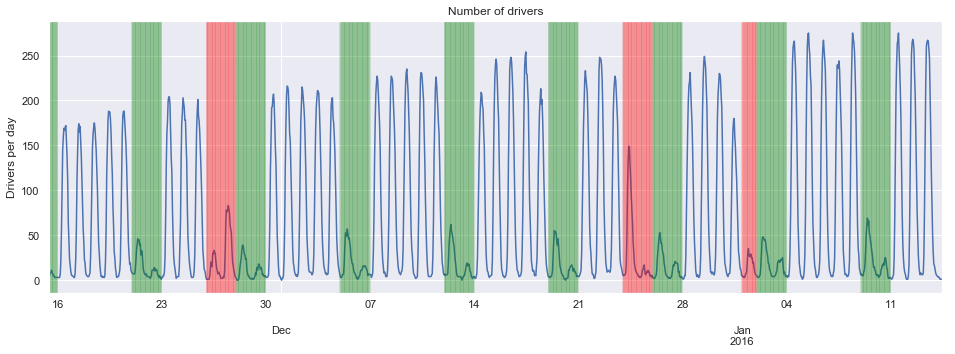

In [224]:
title='Number of drivers'
ylabel='Drivers per day'
xlabel='' # we don't really need a label here

ax = df_for_ln['num_drivers'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df_for_ln.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='red', alpha = 0.2);  # add a semi-transparent red line
for x in df_for_ln.query('weekend==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='green', alpha = 0.2);  # add a semi-transparent red line


In [41]:
df_for_ln.head()

,num_trips,num_drivers,week_of_day,weekend,hour_of_day,peak_hour,holiday
hour,,,,,,,
2015-11-15 10:00:00,1,3,6,1,10,1,0
2015-11-15 11:00:00,4,6,6,1,11,1,0
2015-11-15 12:00:00,6,8,6,1,12,1,0
2015-11-15 13:00:00,7,9,6,1,13,1,0
2015-11-15 14:00:00,8,11,6,1,14,1,0


In [42]:
df_for_ln['days_since_nov15'] = (df_for_ln.index - pd.to_datetime('2015-11-15')).days

In [43]:
lm_vars = list(df_for_ln.columns[-6:-1])

In [44]:
lm_vars

['week_of_day', 'weekend', 'hour_of_day', 'peak_hour', 'holiday']

In [45]:
train_date_end = '2015-12-30'


In [203]:
X_train = df_for_ln.loc[df_for_ln.index<train_date_end,lm_vars].values
X_test = df_for_ln.loc[df_for_ln.index>=train_date_end,lm_vars].values
y_train =df_for_ln.loc[df_for_ln.index<train_date_end,'num_drivers'].values
y_test =df_for_ln.loc[df_for_ln.index>=train_date_end,'num_drivers'].values
dates_test = df_for_ln[df_for_ln.index>=train_date_end].index.values
dates_train = df_for_ln[df_for_ln.index<train_date_end].index.values


In [47]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [95]:
coeff_df = pd.DataFrame(lm.coef_,lm_vars,columns=['Coefficient'])
coeff_df

,Coefficient
week_of_day,-1.497152
weekend,-69.424231
hour_of_day,0.392795
peak_hour,103.380757
holiday,-59.353402


In [96]:
predictions = lm.predict(X_test)

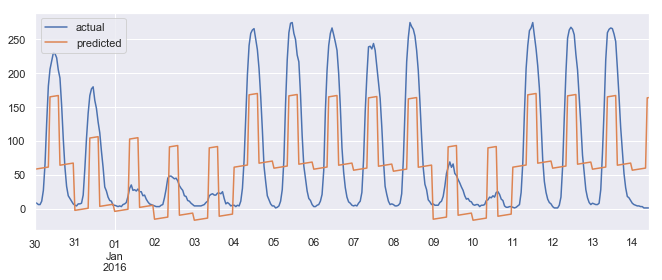

In [97]:
pred_df = pd.DataFrame((np.stack([y_test, predictions], axis=-1)))
pred_df.index = dates_test
pred_df.rename(columns={0:'actual',1:'predicted'}).plot(label=['actual','predicted'])


In [98]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R square:', lm.score(X_test,y_test))

MAE: 53.12360424496832
MSE: 4045.0833471133224
RMSE: 63.60096970261792
R square: 0.5085332631304338


# ARIMA

## Seasonal decomposition 

### Hourly seasonality 

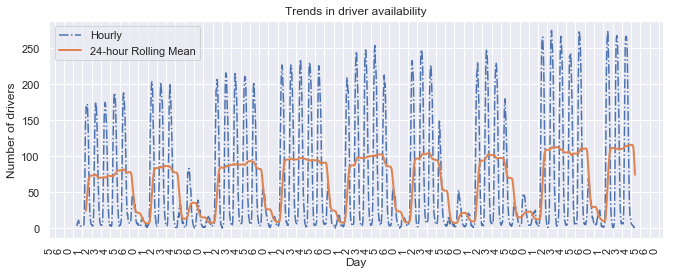

In [16]:
# Plot hourly, 24-hour rolling mean, and 7-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(df_hourly['driver_id'], markersize=2,
linestyle='-.', label='Hourly')

ax.plot(df_hourly['driver_id'].rolling(24).mean(), linewidth=2, label='24-hour Rolling Mean')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%w'))

ax.legend()
ax.set_xlabel('Day')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

ax.set_ylabel('Number of drivers')
ax.set_title('Trends in driver availability');
plt.show()

<Figure size 792x288 with 0 Axes>

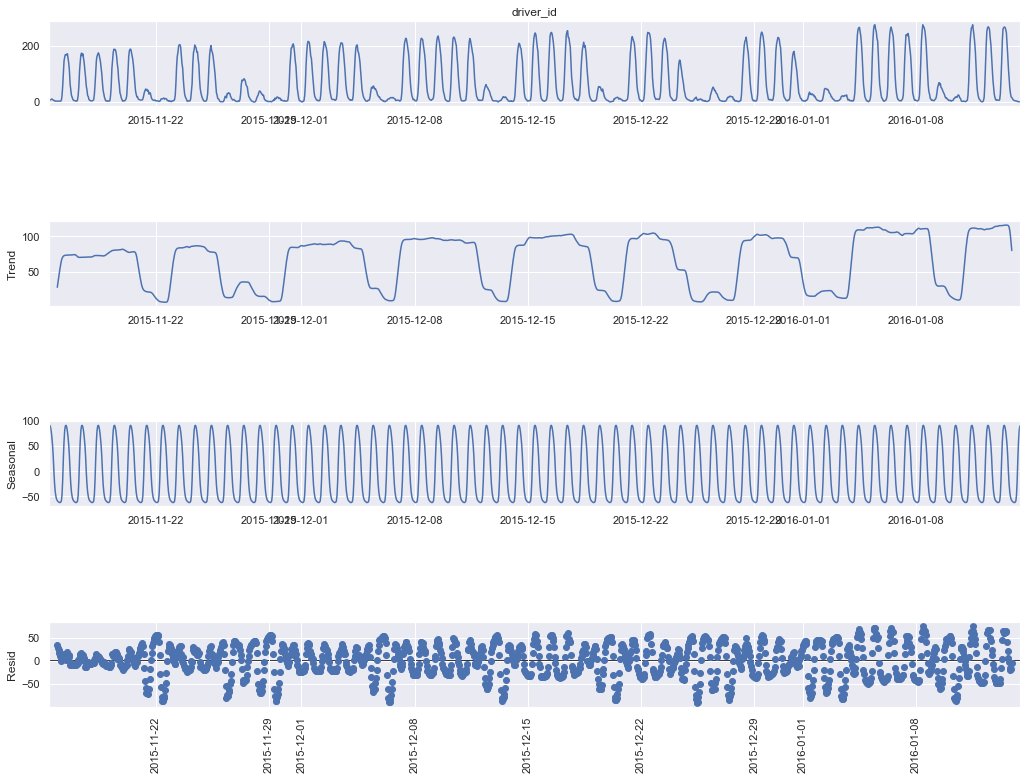

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_hourly['driver_id'], model='additive', period=24)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)
plt.xticks(rotation=90)
plt.show()

### Daily 

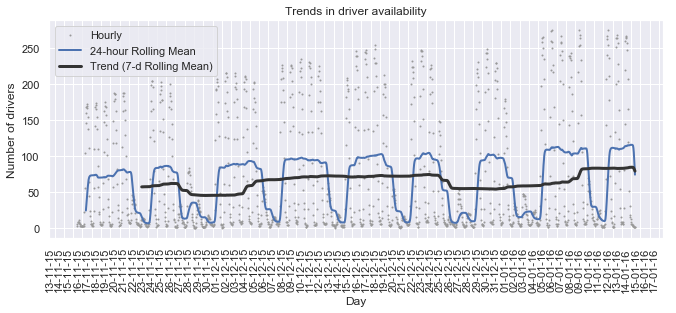

In [101]:
# Plot hourly, 24-hour rolling mean, and 7-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(df_hourly['driver_id'], marker='.', markersize=2, color='0.6',
linestyle='None', label='Hourly')

ax.plot(df_hourly['driver_id'].rolling(24).mean(), linewidth=2, label='24-hour Rolling Mean')
ax.plot(df_hourly['driver_id'].rolling(24*7).mean(), color='0.2', linewidth=3,
label='Trend (7-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

ax.legend()
ax.set_xlabel('Day')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

ax.set_ylabel('Number of drivers')
ax.set_title('Trends in driver availability');
plt.show()

<Figure size 792x288 with 0 Axes>

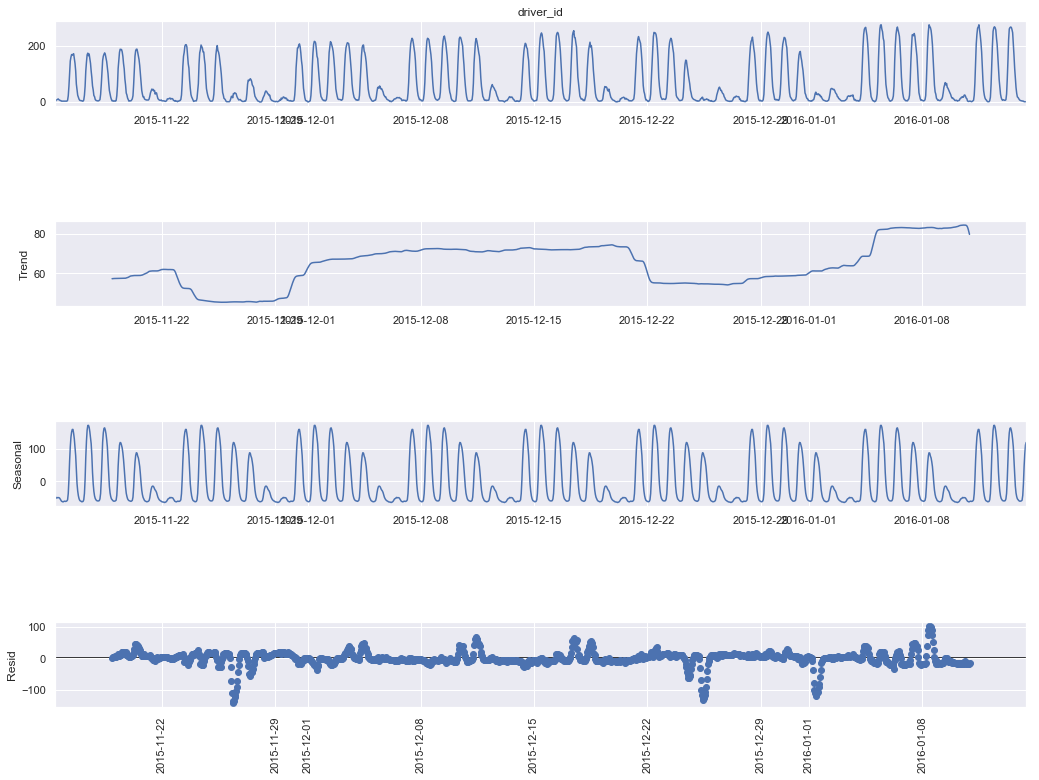

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_hourly['driver_id'], model='additive', period=24*7)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)
plt.xticks(rotation=90)
plt.show()

In [103]:
from statsmodels.tsa.stattools import adfuller

In [109]:
dftest = adfuller(df_hourly.driver_id, autolag='AIC', maxlag = 24)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

print(dfoutput)
print(dftest)

p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.207806e+00
p-value                        5.602136e-08
#Lags Used                     2.300000e+01
Number of Observations Used    1.417000e+03
Critical Value (1%)           -3.434973e+00
Critical Value (5%)           -2.863582e+00
Critical Value (10%)          -2.567857e+00
dtype: float64
(-6.207806095841718, 5.602135706186296e-08, 23, 1417, {'1%': -3.434973278556316, '5%': -2.8635818545830376, '10%': -2.567857072940785}, 9997.654121429427)


In [104]:
dftest = adfuller(df_hourly.driver_id, autolag='AIC', maxlag = 24*7)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

print(dfoutput)

p-value = 0.2763. The series is likely non-stationary.
Test Statistic                   -2.023582
p-value                           0.276330
#Lags Used                      168.000000
Number of Observations Used    1272.000000
Critical Value (1%)              -3.435501
Critical Value (5%)              -2.863815
Critical Value (10%)             -2.567981
dtype: float64


# Seasonal persistence

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# weekly window
scores=[]
hours = np.arange(1,168)
for hr in hours:
    # walk-forward validation
    history = [x for x in y_train]
    predictions = list()
    for i in range(len(y_test)):
        # collect obs
        obs = list()
        for y in range(1, hr+1):
            obs.append(history[-(y*24)])
        # make prediction
        yhat = np.mean(obs)
        predictions.append(yhat)
        # observation
#         history.append(y_test[i])
    # report performance
    rmse = sqrt(mean_squared_error(y_test, predictions))
    scores.append(rmse)
    print('Hour=%d, RMSE: %.3f' % (hr, rmse))
plt.plot(hours, scores)
plt.show()

Hour=1, RMSE: 113.162
Hour=2, RMSE: 114.369
Hour=3, RMSE: 114.572
Hour=4, RMSE: 114.674
Hour=5, RMSE: 114.491
Hour=6, RMSE: 114.369
Hour=7, RMSE: 113.763
Hour=8, RMSE: 113.763
Hour=9, RMSE: 113.830
Hour=10, RMSE: 113.944
Hour=11, RMSE: 113.982
Hour=12, RMSE: 113.712
Hour=13, RMSE: 113.763
Hour=14, RMSE: 113.849
Hour=15, RMSE: 113.924
Hour=16, RMSE: 113.951
Hour=17, RMSE: 113.976
Hour=18, RMSE: 113.897
Hour=19, RMSE: 113.922
Hour=20, RMSE: 113.944
Hour=21, RMSE: 113.878
Hour=22, RMSE: 113.790
Hour=23, RMSE: 113.763
Hour=24, RMSE: 113.737
Hour=25, RMSE: 113.787
Hour=26, RMSE: 113.739
Hour=27, RMSE: 113.651
Hour=28, RMSE: 113.655
Hour=29, RMSE: 113.742
Hour=30, RMSE: 113.783
Hour=31, RMSE: 113.860
Hour=32, RMSE: 113.914
Hour=33, RMSE: 113.964
Hour=34, RMSE: 114.029
Hour=35, RMSE: 114.056
Hour=36, RMSE: 114.082
Hour=37, RMSE: 114.106
Hour=38, RMSE: 114.113
Hour=39, RMSE: 114.057
Hour=40, RMSE: 114.065
Hour=41, RMSE: 114.087
Hour=42, RMSE: 114.094
Hour=43, RMSE: 114.086
Hour=44, RMSE: 114.1

IndexError: list index out of range

Days=1, RMSE: 113.162
Days=2, RMSE: 114.369
Days=3, RMSE: 114.572
Days=4, RMSE: 114.674
Days=5, RMSE: 114.491
Days=6, RMSE: 114.369


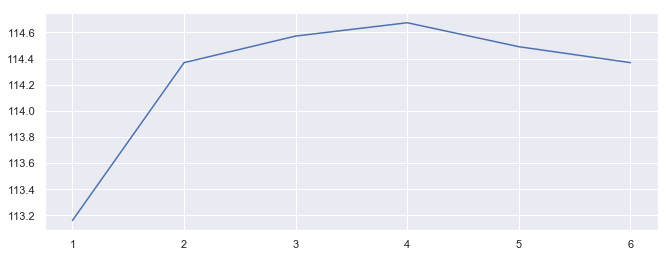

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# weekly window
scores=[]
hours = np.arange(1,7)
for hr in hours:
    # walk-forward validation
    history = [x for x in y_train]
    predictions = list()
    for i in range(len(y_test)):
        # collect obs
        obs = list()
        for y in range(1, hr+1):
            obs.append(history[-(y*24)])
        # make prediction
        yhat = np.mean(obs)
        predictions.append(yhat)
        # observation
#         history.append(y_test[i])
    # report performance
    rmse = sqrt(mean_squared_error(y_test, predictions))
    scores.append(rmse)
    print('Days=%d, RMSE: %.3f' % (hr, rmse))
plt.plot(hours, scores)
plt.show()

## Differencing 

In [69]:
def diff_data(df, lag=0):
    diff = []
    for i in range(lag,len(df)):
        diff.append(df[i] - df[i-lag]
                )
    return np.array(diff)

def inverse_diff(df, y_pred, lag=0):
    return y_pred + df[-lag]

## Try some stuff 

#### Finding p,d,q 

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


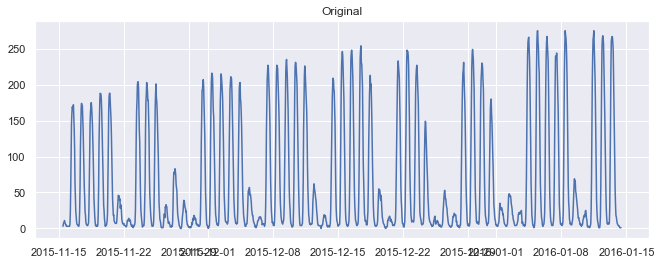

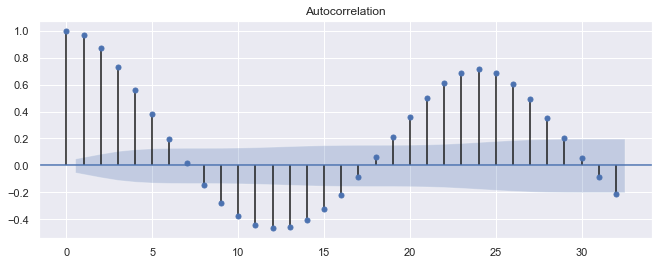

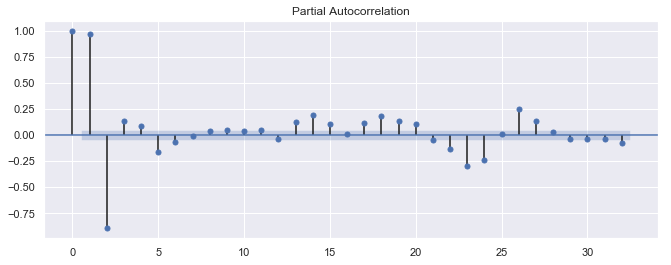

In [21]:
plt.plot(df_hourly.driver_id); 
plt.title('Original')
plot_acf(df_hourly.driver_id.dropna());
plot_pacf(df_hourly.driver_id.dropna());

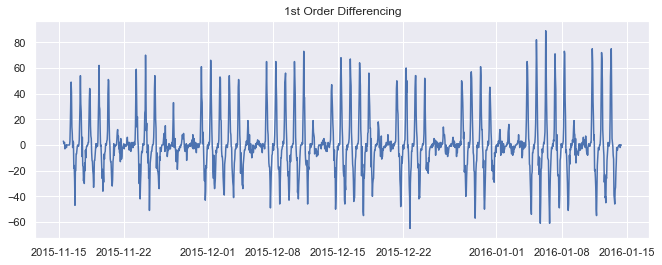

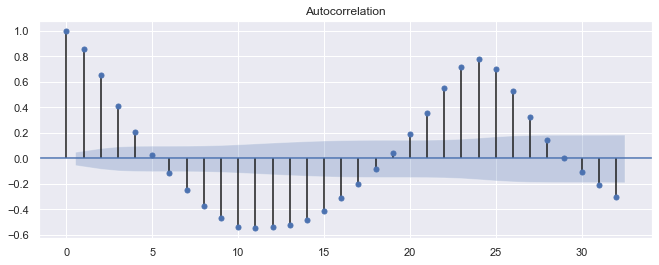

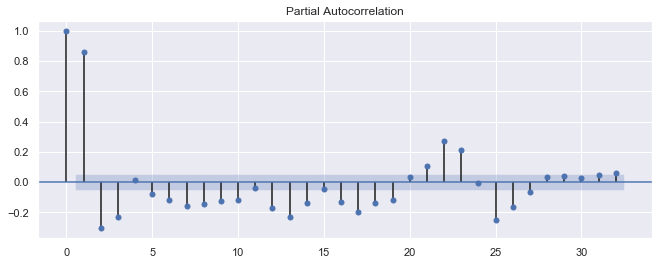

In [51]:
# # 1st Differencing
plt.plot(df_hourly.driver_id.diff(1)); 
plt.title('1st Order Differencing')
plot_acf(df_hourly.driver_id.diff(1).dropna());
plot_pacf(df_hourly.driver_id.diff(1).dropna());

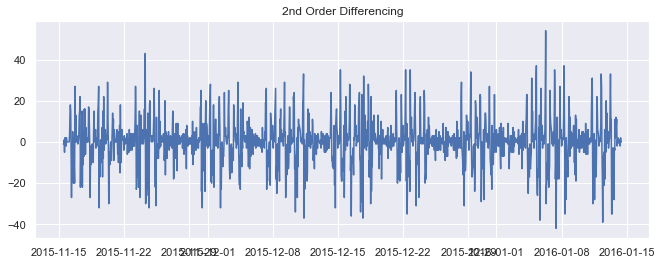

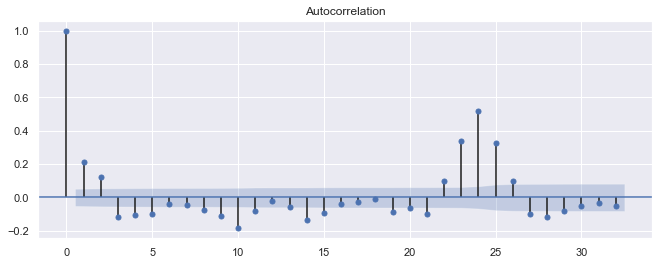

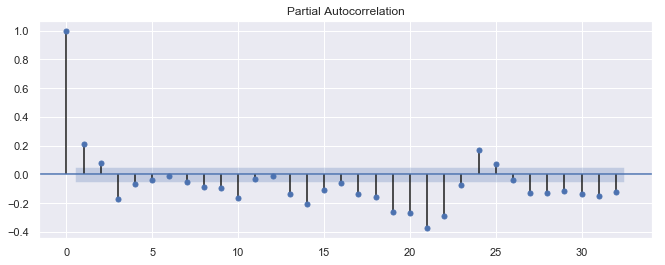

In [22]:
# # 2nd Differencing
plt.plot(df_hourly.driver_id.diff().diff()); 
plt.title('2nd Order Differencing')
plot_acf(df_hourly.driver_id.diff().diff().dropna());
plot_pacf(df_hourly.driver_id.diff().diff().dropna());

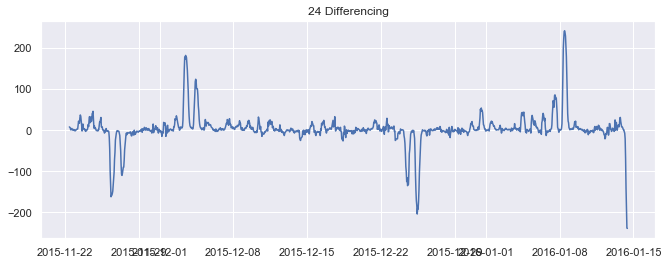

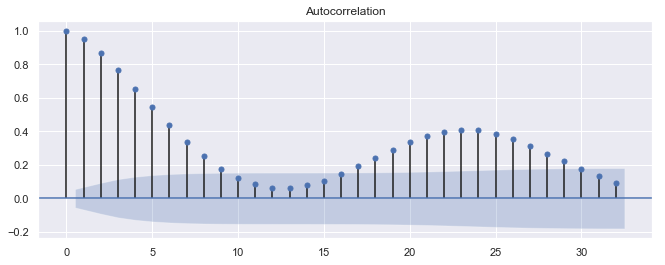

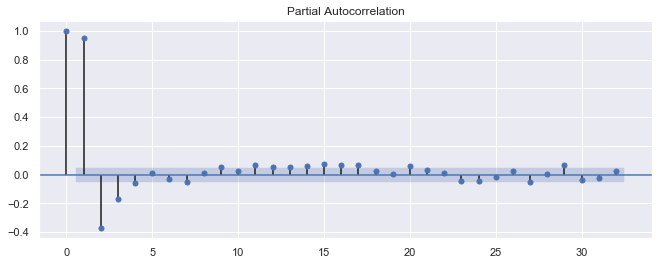

In [67]:
plt.plot(df_hourly.driver_id.diff(24*7)); 
plt.title('24 Differencing')
plot_acf(df_hourly.driver_id.diff(24*7).dropna());
plot_pacf(df_hourly.driver_id.diff(24*7).dropna());


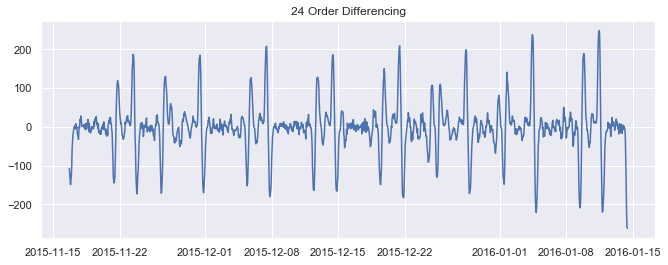

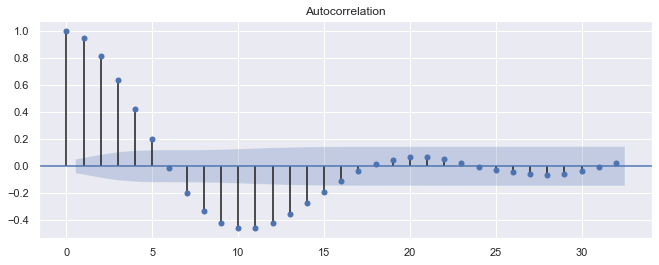

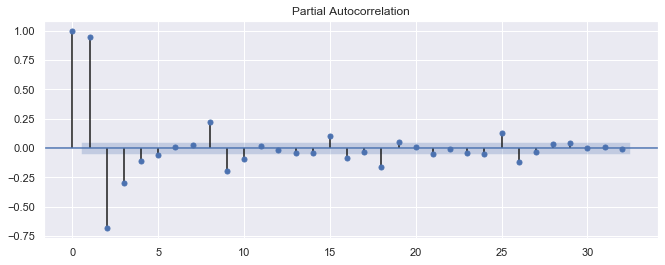

In [58]:
plt.plot(df_hourly.driver_id.diff(24).diff(7)); 
plt.title('24 Order Differencing')
plot_acf(df_hourly.driver_id.diff(24).diff(7).dropna());
plot_pacf(df_hourly.driver_id.diff(24).diff(7).dropna());


### Prepare data 

In [70]:
y_train =df_hourly.loc[df_hourly.index<'2015-12-30','driver_id'].values
y_train_df = df_hourly.loc[df_hourly.index<'2015-12-30','driver_id']
y_test =df_hourly.loc[df_hourly.index>='2015-12-30','driver_id'].values
y_test_df = df_hourly.loc[df_hourly.index>='2015-12-30','driver_id']
train_dates = df_hourly.loc[df_hourly.index<'2015-12-30'].index.values
test_dates = df_hourly.loc[df_hourly.index>='2015-12-30'].index.values

In [101]:
# y_train_diffdaily = diff_data(y_train_df, lag=24)
y_train_diffweekly = diff_data(y_train_df, lag=24*7)
train_dates_diffweekly = train_dates[(24*7):]

### ARIMA on original data 

In [115]:
from statsmodels.tsa.arima_model import ARIMA
orig_model = ARIMA(y_train_df, order=(7,0,1))
orig_model_fit = orig_model.fit()
print(orig_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:              driver_id   No. Observations:                 1070
Model:                     ARMA(7, 1)   Log Likelihood               -3870.855
Method:                       css-mle   S.D. of innovations              8.987
Date:                Wed, 18 Mar 2020   AIC                           7761.710
Time:                        17:28:56   BIC                           7811.464
Sample:                    11-15-2015   HQIC                          7780.557
                         - 12-29-2015                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              64.7310      8.058      8.033      0.000      48.938      80.524
ar.L1.driver_id     2.7484      0.035     77.958      0.000       2.679       2.818
ar.L2.driver_id    -2.5075      

In [116]:
def check_resid(mod):
    residuals = pd.DataFrame(mod.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

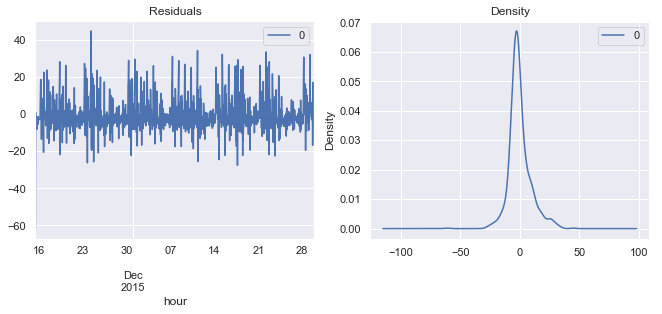

In [117]:
check_resid(orig_model_fit)

### ARIMA Follow github https://github.com/shaw-anugya/Time-Series/blob/master/SARIMAX_Implementation.ipynb

In [114]:
import pmdarima as pm

model_autoarima = pm.auto_arima(y_train_df, seasonal=True,m=24)

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [122]:
model_autoarima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1070
Model:             SARIMAX(2, 0, 2)x(1, 0, 2, 24)   Log Likelihood               -3655.801
Date:                            Wed, 18 Mar 2020   AIC                           7329.602
Time:                                    19:22:41   BIC                           7374.381
Sample:                                         0   HQIC                          7346.565
                                           - 1070                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0060      0.006      0.936      0.349      -0.007       0.018
ar.L1          1.7387      0.031     56.769      0.000       1.679       1.799
ar.L2         -0.7856      0.030    -26.283      0.000      -0.844      -0.727
ma.L1         -0.1769      0.038     -4.698      0.000      -0.251      -0.103
ma.L2          0.1518      0.038      4.002      0.000       0.077       0.226
ar.S.L24       0.9982      0.002    589.935      0.000       0.995       1.002
ma.S.L24      -0.7855      0.026    -30.466      0.000      -0.836      -0.735
ma.S.L48      -0.1654      0.024     -6.964      0.000      -0.212      -0.119
sigma2        52.2655      1.855     28.174      0.000      48.630      55.901
===================================================================================
Ljung-Box (Q):                       86.18   Jarque-Bera (JB):                98.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.18
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

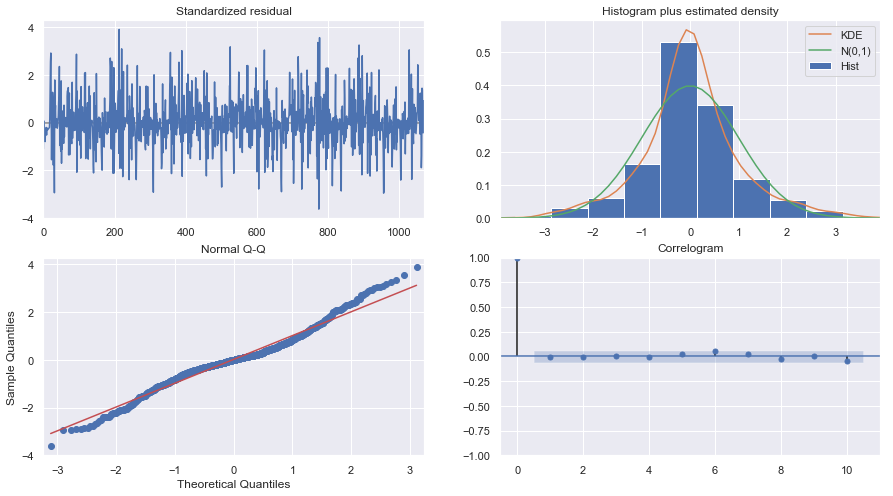

In [123]:
model_autoarima.plot_diagnostics(figsize=(15,8))
plt.show()


In [124]:
train = df_for_ln.loc[df_for_ln.index<train_date_end]
test = df_for_ln.loc[df_for_ln.index>=train_date_end]
# y_train =df_for_ln.loc[df_for_ln.index<train_date_end,'num_drivers'].values
# y_test =df_for_ln.loc[df_for_ln.index>=train_date_end,'num_drivers'].values
# dates_test = df_for_ln[df_for_ln.index>=train_date_end].index.values

In [134]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['num_drivers'],order = (2,0,2), seasonal_order=(1,0,2,24),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        num_drivers   No. Observations:                 1070
Model:             SARIMAX(2, 0, 2)x(1, 0, 2, 24)   Log Likelihood               -3656.804
Date:                            Wed, 18 Mar 2020   AIC                           7329.607
Time:                                    19:33:57   BIC                           7369.411
Sample:                                11-15-2015   HQIC                          7344.686
                                     - 12-29-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7381      0.031     55.220      0.000       1.676       1.800
ar.L2         -0.7804      0.031    -25.393      0.000      -0.841      -0.720
ma.L1         -0.1788      0.038     -4.701      0.000      -0.253      -0.104
ma.L2          0.1492      0.038      3.925      0.000       0.075       0.224
ar.S.L24       0.9992      0.001   1011.416      0.000       0.997       1.001
ma.S.L24      -0.7943      0.026    -30.395      0.000      -0.846      -0.743
ma.S.L48      -0.1654      0.024     -7.017      0.000      -0.212      -0.119
sigma2        51.2146      1.814     28.239      0.000      47.660      54.769
===================================================================================
Ljung-Box (Q):                       84.86   Jarque-Bera (JB):                96.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.08
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [127]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('Predicted')


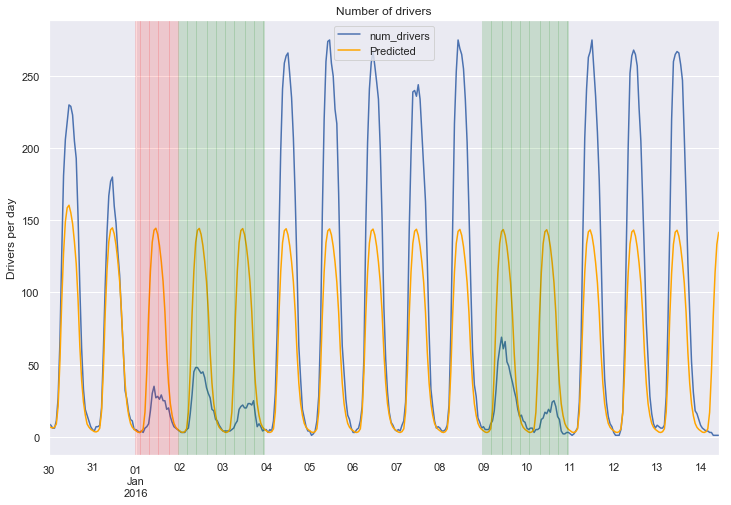

In [128]:
ylabel='Drivers per day'
xlabel=''

ax = test['num_drivers'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='red', alpha = 0.2);  # add a semi-transparent red line
for x in test.query('weekend==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='green', alpha = 0.2);  # add a semi-transparent red line


In [131]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['num_drivers'], predictions)
error2 = rmse(test['num_drivers'], predictions)

print(f'SARIMA MSE Error: {error1:11.10}')
print(f'SARIMA RMSE Error: {error2:11.10}')

SARIMA MSE Error:  4022.02357
SARIMA RMSE Error: 63.41942581


In [146]:
model = SARIMAX(train['num_drivers'],exog=train[['holiday','weekend']],order=(2,0,2),seasonal_order=(1,0,2,24)
                ,enforce_invertibility=False)
results = model.fit()
results.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        num_drivers   No. Observations:                 1070
Model:             SARIMAX(2, 0, 2)x(1, 0, 2, 24)   Log Likelihood               -3699.627
Date:                            Wed, 18 Mar 2020   AIC                           7419.253
Time:                                    19:41:57   BIC                           7469.007
Sample:                                11-15-2015   HQIC                          7438.101
                                     - 12-29-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       21.7303      1.654     13.139      0.000      18.489      24.972
weekend        5.6325      2.000      2.816      0.005       1.712       9.553
ar.L1          1.7527      0.034     51.159      0.000       1.686       1.820
ar.L2         -0.7719      0.034    -22.568      0.000      -0.839      -0.705
ma.L1         -0.1454      0.042     -3.470      0.001      -0.228      -0.063
ma.L2          0.1146      0.040      2.849      0.004       0.036       0.193
ar.S.L24       0.9997      0.001   1185.636      0.000       0.998       1.001
ma.S.L24      -0.8286      0.034    -24.628      0.000      -0.895      -0.763
ma.S.L48      -0.1458      0.028     -5.271      0.000      -0.200      -0.092
sigma2        59.5114      2.569     23.164      0.000      54.476      64.547
===================================================================================
Ljung-Box (Q):                      109.80   Jarque-Bera (JB):                66.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.08
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

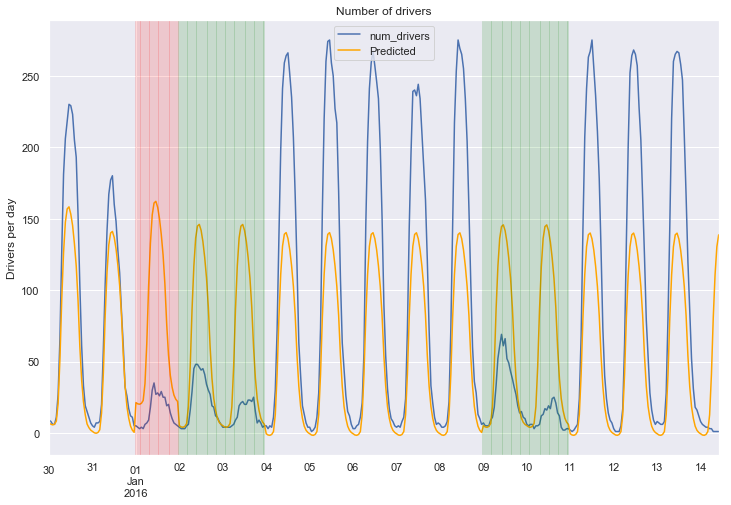

In [147]:
ylabel='Drivers per day'
xlabel=''
predictions = results.predict(start=start, end=end, exog=test[['holiday','weekend']], dynamic=False).rename('Predicted')

ax = test['num_drivers'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='red', alpha = 0.2);  # add a semi-transparent red line
for x in test.query('weekend==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='green', alpha = 0.2);  # add a semi-transparent red line


#### with differencing 

In [152]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['num_drivers'].diff(24*7).dropna()
                ,order = (2,0,2), seasonal_order=(1,0,2,24),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        num_drivers   No. Observations:                  902
Model:             SARIMAX(2, 0, 2)x(1, 0, 2, 24)   Log Likelihood               -3109.405
Date:                            Wed, 18 Mar 2020   AIC                           6234.810
Time:                                    19:44:07   BIC                           6273.247
Sample:                                11-22-2015   HQIC                          6249.492
                                     - 12-29-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7211      0.045     38.310      0.000       1.633       1.809
ar.L2         -0.7646      0.043    -17.759      0.000      -0.849      -0.680
ma.L1         -0.5166      0.048    -10.841      0.000      -0.610      -0.423
ma.L2          0.1230      0.036      3.397      0.001       0.052       0.194
ar.S.L24      -0.9520      0.023    -41.938      0.000      -0.997      -0.908
ma.S.L24       1.1343      0.036     31.357      0.000       1.063       1.205
ma.S.L48       0.2391      0.030      7.859      0.000       0.179       0.299
sigma2        57.0705      1.702     33.530      0.000      53.735      60.406
===================================================================================
Ljung-Box (Q):                       72.71   Jarque-Bera (JB):               780.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.38
Prob(H) (two-sided):                  0.69   Kurtosis:                         7.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [163]:
len(results.fittedvalues[:5]), len(train)-(24*7)

(5, 902)

In [169]:
hist = [x for x in y_train]

y_insamples=[]
for f in results.fittedvalues:
    y_pred = inverse_diff(hist, f, 24*7)
#     print(f, y_pred, hist[-(24*7)])
    hist.append(y_pred)
    y_insamples.append(y_pred)

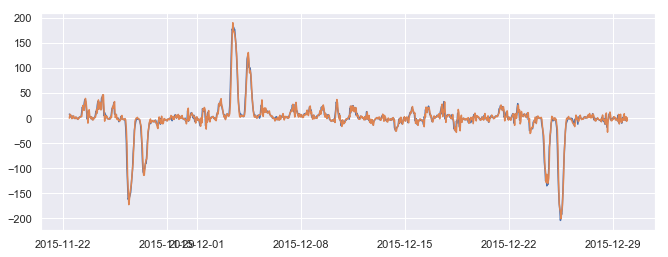

In [175]:
plt.plot(train['num_drivers'].diff(24*7).dropna())
plt.plot(results.fittedvalues)

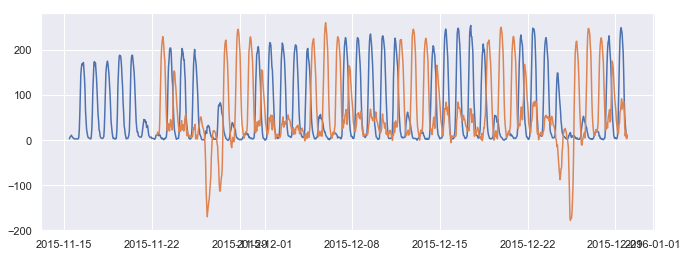

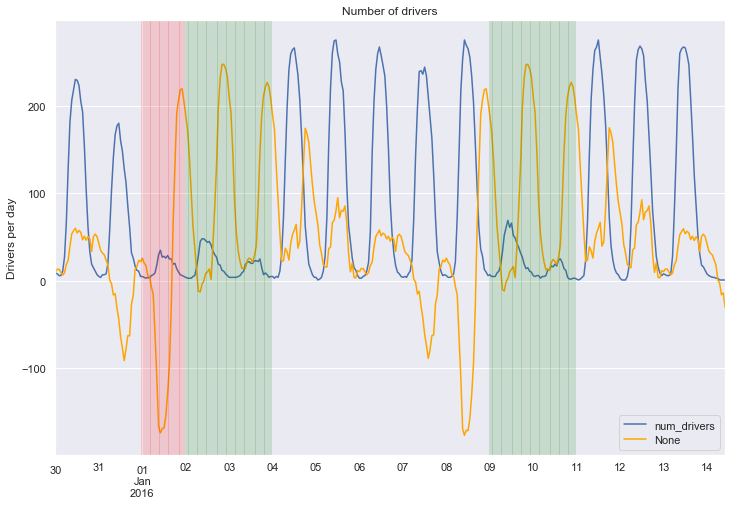

In [182]:
# Obtain predicted values
start=len(train)-(24*7)
end=start+len(test)-1
ylabel='Drivers per day'
xlabel=''
predictions = results.predict(start=start, end=end, exog=test[['holiday','weekend']], dynamic=True).rename('Predicted')

hist = [x for x in y_insamples]

y_preds=[]
for f in predictions:
    y_pred = inverse_diff(hist, f, 24*7)
    hist.append(y_pred)
    y_preds.append(y_pred)

fc_series = pd.Series(y_preds, index=dates_test)

ax = test['num_drivers'].plot(legend=True,figsize=(12,8),title=title)

fc_series.plot(legend=True,color = 'orange')

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='red', alpha = 0.2);  # add a semi-transparent red line
for x in test.query('weekend==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='green', alpha = 0.2);  # add a semi-transparent red line


In [184]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['num_drivers'], y_preds)
error2 = rmse(test['num_drivers'], y_preds)

print(f'SARIMA MSE Error: {error1:11.10}')
print(f'SARIMA RMSE Error: {error2:11.10}')

SARIMA MSE Error: 19477.01449
SARIMA RMSE Error: 139.5600748


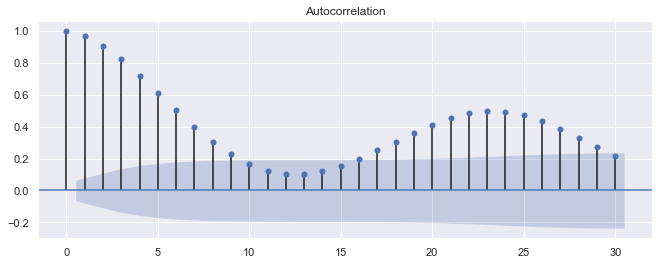

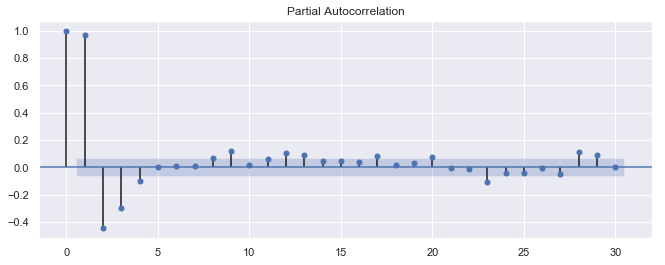

In [77]:
plot_acf(y_train_diffweekly)
plot_pacf(y_train_diffweekly);


In [159]:
for i in range(3,8):
    for k in range(1,3):
        for j in range(1,5):
            diffweekly_model = ARIMA(y_train_df, order=(i,k,j))
            diffweekly_model_fit = diffweekly_model.fit()
            print(i,k,j,diffweekly_model_fit.aic)

3 1 1 7804.460660383113
3 1 2 7803.710962593892


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [84]:
for i in range(3,8):
    for k in range(0,3):
        for j in range(1,2):
            diffweekly_model = ARIMA(y_train_diffweekly, order=(i,k,j))
            diffweekly_model_fit = diffweekly_model.fit()
            print(i,k,j,diffweekly_model_fit.aic)

3 0 1 6283.751430384133
3 1 1 6283.8618658067135
3 2 1 6346.027537490737
4 0 1 6284.555068323367
4 1 1 6266.666565262621
4 2 1 6342.679875778322
5 0 1 6268.935586014888
5 1 1 6264.9174026699075
5 2 1 6338.760730326227
6 0 1 6266.927049954668
6 1 1 6262.827599828958
6 2 1 6335.6274137373675
7 0 1 6290.0998731699
7 1 1 6258.488673728167
7 2 1 6325.145589841333


In [102]:
from statsmodels.tsa.arima_model import ARIMA
diffweekly_model = ARIMA(y_train_diffweekly, order=(7,1,1), dates=train_dates_diffweekly, freq='H')
diffweekly_model_fit = diffweekly_model.fit()
print(diffweekly_model_fit.aic)

6258.488673728167


In [103]:
diffweekly_model_fit.forecast(len(dates_test))[0]  # 95% conf

array([-3.82238667, -4.12321999, -4.57430186, -5.06369693, -4.79789328,
       -4.93160381, -4.72192383, -4.4213429 , -4.08214441, -3.69361515,
       -3.27854348, -2.91962342, -2.58950617, -2.32793296, -2.14363968,
       -2.03808909, -2.01191098, -2.06042835, -2.16992922, -2.32836692,
       -2.51964549, -2.72754066, -2.93683565, -3.13373296, -3.30669109,
       -3.44733814, -3.55028873, -3.61338955, -3.63746519, -3.6258966 ,
       -3.58412501, -3.51905863, -3.43841466, -3.35011687, -3.26172505,
       -3.17995788, -3.1103296 , -3.05690743, -3.02219456, -3.00713508,
       -3.01122336, -3.03270103, -3.06881751, -3.11612911, -3.17081208,
       -3.22896666, -3.28689225, -3.34131811, -3.38957896, -3.4297294 ,
       -3.46059642, -3.48177307, -3.49356059, -3.49686855, -3.4930845 ,
       -3.48392563, -3.47128446, -3.45707974, -3.4431224 , -3.43100371,
       -3.42201111, -3.41707415, -3.41674102, -3.42118373, -3.43022846,
       -3.44340617, -3.46001772, -3.47920741, -3.50003904, -3.52

In [97]:
fc = diffweekly_model_fit.forecast(len(dates_test))[0]  # 95% conf

# SARIMAX

In [191]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['num_drivers'],seasonal_order=(7,0,1,24),enforce_invertibility=False)
results = model.fit()
results.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          num_drivers   No. Observations:                 1070
Model:             SARIMAX(1, 0, 0)x(7, 0, [1], 24)   Log Likelihood               -3797.791
Date:                              Wed, 18 Mar 2020   AIC                           7615.581
Time:                                      20:26:08   BIC                           7665.336
Sample:                                  11-15-2015   HQIC                          7634.429
                                       - 12-29-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9671      0.005    192.657      0.000       0.957       0.977
ar.S.L24       0.1790      0.031      5.768      0.000       0.118       0.240
ar.S.L48      -0.0372      0.025     -1.462      0.144      -0.087       0.013
ar.S.L72      -0.0298      0.020     -1.494      0.135      -0.069       0.009
ar.S.L96       0.0465      0.017      2.739      0.006       0.013       0.080
ar.S.L120      0.0390      0.020      1.998      0.046       0.001       0.077
ar.S.L144      0.1455      0.021      6.894      0.000       0.104       0.187
ar.S.L168      0.6262      0.019     33.655      0.000       0.590       0.663
ma.S.L24       0.1600      0.038      4.190      0.000       0.085       0.235
sigma2        61.7037      1.681     36.705      0.000      58.409      64.999
===================================================================================
Ljung-Box (Q):                     1062.14   Jarque-Bera (JB):               920.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.31
Prob(H) (two-sided):                  0.97   Kurtosis:                         7.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [192]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('Predicted')


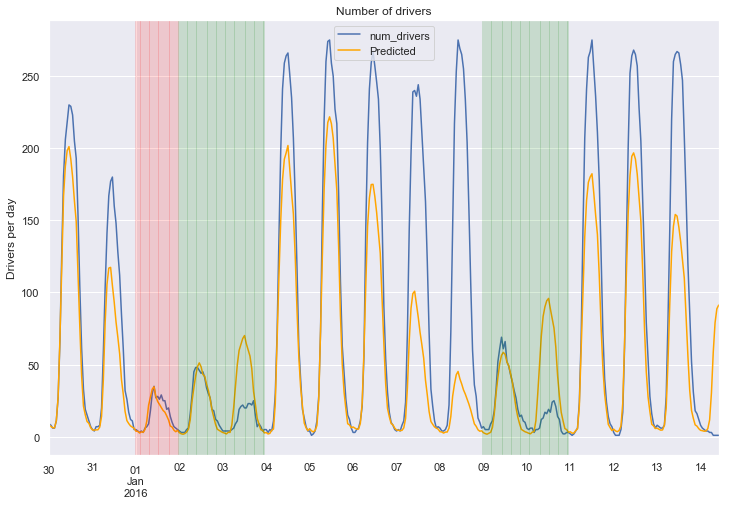

In [193]:
ax = test['num_drivers'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='red', alpha = 0.2);  # add a semi-transparent red line
for x in test.query('weekend==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='green', alpha = 0.2);  # add a semi-transparent red line


In [194]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['num_drivers'], predictions)
error2 = rmse(test['num_drivers'], predictions)

print(f'SARIMA MSE Error: {error1:11.10}')
print(f'SARIMA RMSE Error: {error2:11.10}')

SARIMA MSE Error: 2897.241751
SARIMA RMSE Error: 53.82603228


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          num_drivers   No. Observations:                 1070
Model:             SARIMAX(1, 0, 0)x(7, 0, [1], 24)   Log Likelihood               -3825.177
Date:                              Wed, 18 Mar 2020   AIC                           7674.353
Time:                                      21:03:38   BIC                           7734.058
Sample:                                  11-15-2015   HQIC                          7696.971
                                       - 12-29-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       22.8726      1.740     13.146      0.000      19.463      26.283
weekend       13.2155      4.000      3.304      0.001       5.376      21.055
ar.L1          0.9581      0.005    205.214      0.000       0.949       0.967
ar.S.L24       0.1792      0.032      5.646      0.000       0.117       0.241
ar.S.L48      -0.0461      0.026     -1.782      0.075      -0.097       0.005
ar.S.L72      -0.0237      0.020     -1.163      0.245      -0.064       0.016
ar.S.L96       0.0355      0.018      2.025      0.043       0.001       0.070
ar.S.L120      0.0622      0.020      3.100      0.002       0.023       0.101
ar.S.L144      0.1359      0.022      6.247      0.000       0.093       0.179
ar.S.L168      0.6241      0.019     33.019      0.000       0.587       0.661
ma.S.L24       0.1533      0.038      3.998      0.000       0.078       0.228
sigma2        65.3639      1.924     33.979      0.000      61.594      69.134
===================================================================================
Ljung-Box (Q):                      930.82   Jarque-Bera (JB):               874.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.29
Prob(H) (two-sided):                  0.76   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA MSE Error: 3666.292939
SARIMA RMSE Error: 60.54992105


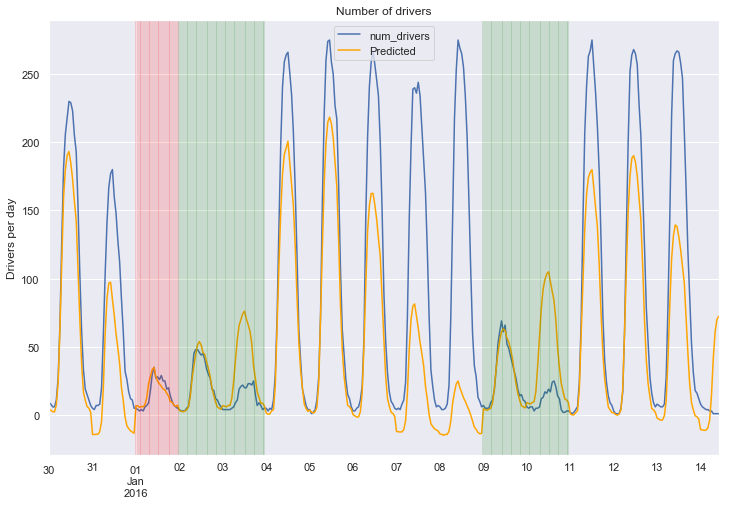

In [197]:
model1 = SARIMAX(train['num_drivers'],exog=train[['holiday','weekend']]#,order=(2,0,2)
                ,seasonal_order=(7,0,1,24)
                ,enforce_invertibility=False)
results1 = model1.fit()
results1.summary()
ylabel='Drivers per day'
xlabel=''
predictions1 = results1.predict(start=start, end=end, exog=test[['holiday','weekend']], dynamic=False).rename('Predicted')

ax = test['num_drivers'].plot(legend=True,figsize=(12,8),title=title)
predictions1.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='red', alpha = 0.2);  # add a semi-transparent red line
for x in test.query('weekend==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='green', alpha = 0.2);  # add a semi-transparent red line
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['num_drivers'], predictions1)
error2 = rmse(test['num_drivers'], predictions1)

print(f'SARIMA MSE Error: {error1:11.10}')
print(f'SARIMA RMSE Error: {error2:11.10}')

In [202]:
def fourier_exogs(df, num, season_period):
    exog_tmp = pd.DataFrame({'date':df.index})
    exog_tmp = exog_tmp.set_index(pd.PeriodIndex(exog_tmp['date'], freq='H'))
    for i in range(1,num+1):
        if season_period==24*7:
            exog_tmp['sin_168'+str(i)] = np.sin(2*i*np.pi*exog_tmp.index.dayofweek/7)
            exog_tmp['cos_168'+str(i)] = np.cos(2*i*np.pi*exog_tmp.index.dayofweek/7)
        if season_period==24:
            exog_tmp['sin_24'+str(i)] = np.sin(2*i*np.pi*exog_tmp.index.hour/24)
            exog_tmp['cos_24'+str(i)] = np.cos(2*i*np.pi*exog_tmp.index.hour/24)
    exog_tmp = exog_tmp.drop(columns=['date'])
    return exog_tmp

In [219]:
def gridsearch_exog(df):
    aic_vals = []
    for i in range(4,10):
        for j in range(4,10):
            exog1 = fourier_exogs(df, i, 24)
            exog2 = fourier_exogs(df, j, 24*7)
            exog = exog1.merge(exog2, left_index=True, right_index=True)
            exog_train = exog[exog.index<=dates_train[-1]]
#             display((exog_train.head()))
#             display(train[['num_drivers']].head())
            sxmodel_tmp = SARIMAX(
                train['num_drivers']
                ,seasonal_order=(7,0,1,24)
                ,exog=exog_train.values
                ,enforce_invertibility=False)
            results = sxmodel_tmp.fit()
#             results.summary()
#             sxmodel_tmp = pm.auto_arima(train['num_drivers'], exogenous=exog_train,
#                            start_p=1, start_q=1,
#                            test='adf',
#                            max_p=3, max_q=3,
#                            start_P=5, max_P=7, seasonal=True,m=24,
#                            d=None, D=0,
#                            error_action='ignore',  
#                            suppress_warnings=True)
            print(i,j,results.aic)
#             aic_vals.append([i,j,sxmodel_tmp.aic()])
    return aic_vals

In [220]:
aics = gridsearch_exog(df_hourly)

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 4 7639.906594968368


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 5 7645.232914496279


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 6 7629.338696781504


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 7 7605.017337638691


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 8 7608.81780287137


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 9 7598.881567452951


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 4 7631.335313485013


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5 5 7645.5158861165155


KeyboardInterrupt: 

In [ ]:
aics.sort(key = lambda x:x[-1])

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA MSE Error:  1884.19287
SARIMA RMSE Error: 43.40729052


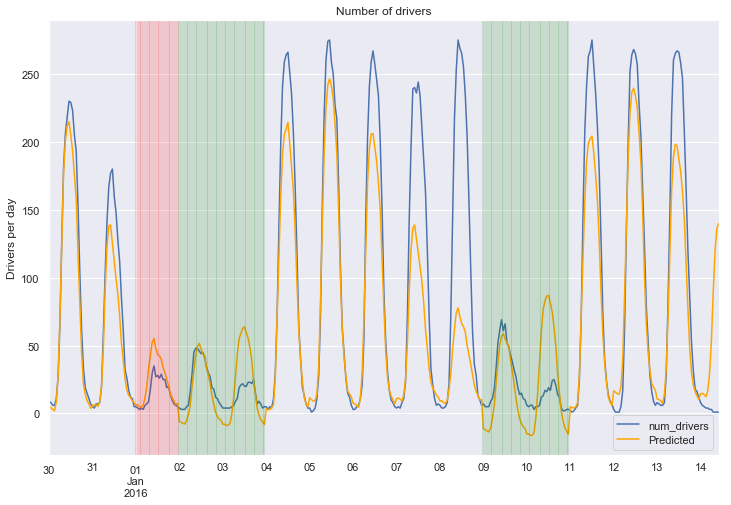

In [223]:
exog1 = fourier_exogs(df_hourly, 4, 24)
exog2 = fourier_exogs(df_hourly, 7, 24*7)
exog = exog1.merge(exog2, left_index=True, right_index=True)
exog_train = exog[exog.index<=dates_train[-1]]
exog_test = exog[exog.index>=dates_test[0]]

sxmodel_tmp = SARIMAX(
    train['num_drivers']
    ,seasonal_order=(7,0,1,24)
    ,exog=exog_train.values
    ,enforce_invertibility=False)
results = sxmodel_tmp.fit()
results.summary()
ylabel='Drivers per day'
xlabel=''
predictions = results.predict(start=start, end=end, exog=exog_test, dynamic=False).rename('Predicted')

ax = test['num_drivers'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='red', alpha = 0.2);  # add a semi-transparent red line
for x in test.query('weekend==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='green', alpha = 0.2);  # add a semi-transparent red line
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['num_drivers'], predictions)
error2 = rmse(test['num_drivers'], predictions)

print(f'SARIMA MSE Error: {error1:11.10}')
print(f'SARIMA RMSE Error: {error2:11.10}')

## SARIMAX with exog variable for holidays 

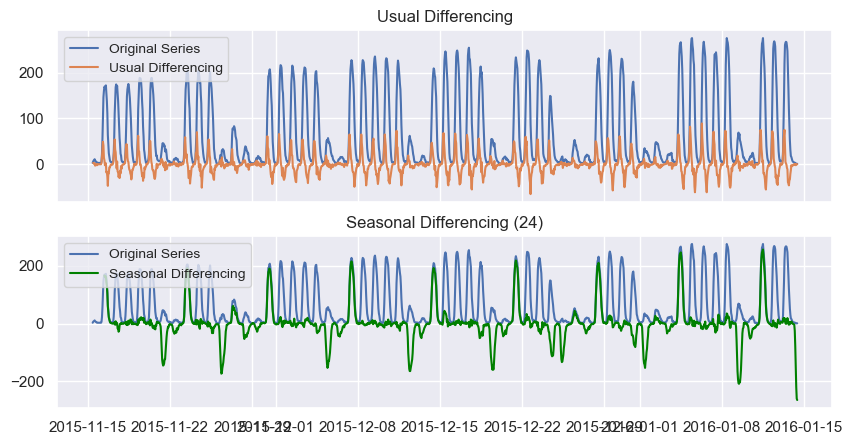

In [185]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df_hourly.driver_id, label='Original Series')
axes[0].plot(df_hourly.driver_id.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df_hourly.driver_id, label='Original Series')
axes[1].plot(df_hourly.driver_id.diff(24), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing (24)')
plt.legend(loc='upper left', fontsize=10)
plt.show()


In [180]:
exog_var_train = [[val[3],val[-2]] for val in X_train]
exog_var_test = [[val[3],val[-2]] for val in X_test]

In [181]:
len(exog_var_train), len(exog_var_test)

(1070, 371)

In [182]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(y_train_df, exogenous=exog_var_train,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=7, max_q=4, m=24,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 24) (constant=True); AIC=7648.676, BIC=7683.345, Time=26.347 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 24) (constant=True); AIC=11368.262, BIC=11388.073, Time=0.329 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 24) (constant=True); AIC=8282.327, BIC=8312.043, Time=29.617 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 24) (constant=True); AIC=10103.131, BIC=10132.848, Time=23.259 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 24) (constant=False); AIC=11367.339, BIC=11382.197, Time=0.879 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 24) (constant=True); AIC=7953.846, BIC=7983.563, Time=5.375 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 1, 24) (constant=True); AIC=7570.778, BIC=7610.400, Time=32.523 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 0, 1)x(0, 1, 2, 24) (constant=True); AIC=7554.423, BIC=7594.045, Time=88.140 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1070
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 24)   Log Likelihood               -3587.793
Date:                              Mon, 16 Mar 2020   AIC                           7193.587
Time:                                      00:07:40   BIC                           7238.161
Sample:                                           0   HQIC                          7210.491
                                             - 1070                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0143      0.022      0.642      0.521      -0.029       0.058
x1             0.0075   2193.307   3.42e-06      1.000   -4298.795    4298.810
x2            -0.8907      8.752     -0.102      0.919     -18.044      16.263
ar.L1          1.7292      0.033     52.790      0.000       1.665       1.793
ar.L2         -0.7737      0.032    -24.077      0.000      -0.837      -0.711
ma.L1         -0.1481      0.039     -3.825      0.000      -0.224      -0.072
ma.L2          0.1741      0.039      4.513      0.000       0.098       0.250
ma.S.L24      -0.9503      0.015    -65.207      0.000      -0.979      -0.922
sigma2        52.6793      1.773     29.706      0.000      49.204      56.155
===================================================================================
Ljung-Box (Q):                       84.41   Jarque-Bera (JB):               110.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.09
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

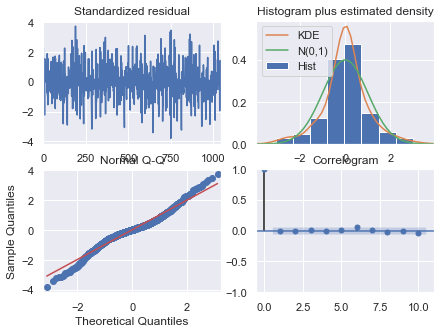

In [183]:
sxmodel.plot_diagnostics(figsize=(7,5));

Test MSE: 13052.955
Test RMSE: 114.250


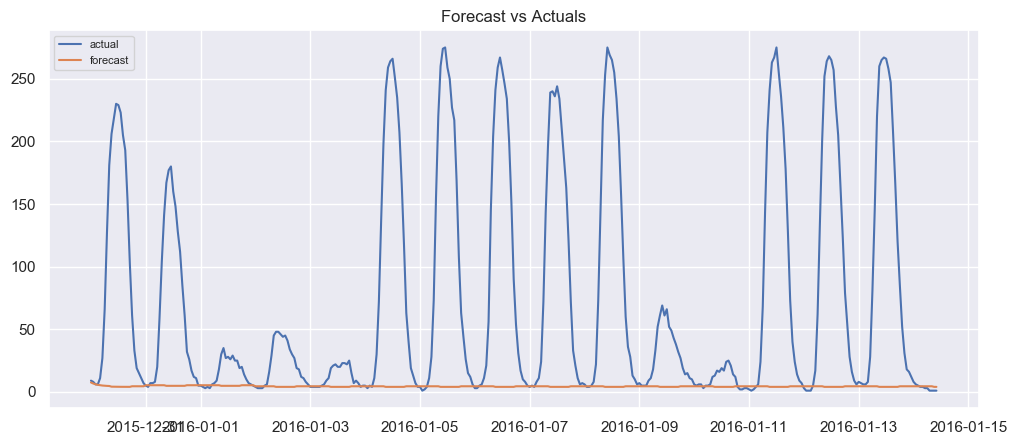

In [194]:
model_arima_exog = ARIMA(y_train_df,order = (2,0,2),exog=exog_var_train
                )
model_arima_exog_fit = model_arima_exog.fit(disp=-1)

# Forecast
fc, se, conf = model_arima_exog_fit.forecast(len(dates_test), exog=exog_var_test, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=dates_test)
lower_series = pd.Series(conf[:, 0], index=dates_test)
upper_series = pd.Series(conf[:, 1], index=dates_test)

# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(y_train_df, label='training')
plt.plot(y_test_df, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
error = metrics.mean_squared_error(y_test, fc)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % (error)**0.5)

plt.show()

In [172]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_smax = SARIMAX(y_train_df,order = (2,0,2),seasonal_order=(0,1,1,24),exog=exog_var_train
                ,initialization='approximate_diffuse'
                )
model_smax_fit = model_smax.fit()
model_smax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            driver_id   No. Observations:                 1070
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 24)   Log Likelihood               -3800.082
Date:                              Sun, 15 Mar 2020   AIC                           7614.165
Time:                                      23:48:57   BIC                           7648.993
Sample:                                  11-15-2015   HQIC                          7627.358
                                       - 12-29-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.9684      8.599     -0.113      0.910     -17.821      15.885
ar.L1          1.7172      0.033     51.924      0.000       1.652       1.782
ar.L2         -0.7632      0.032    -23.759      0.000      -0.826      -0.700
ma.L1         -0.1421      0.039     -3.640      0.000      -0.219      -0.066
ma.L2          0.1784      0.039      4.615      0.000       0.103       0.254
ma.S.L24      -0.9502      0.015    -64.542      0.000      -0.979      -0.921
sigma2        52.4538      1.755     29.883      0.000      49.013      55.894
===================================================================================
Ljung-Box (Q):                       88.10   Jarque-Bera (JB):               140.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Test MSE: 3908.325
Test RMSE: 62.517


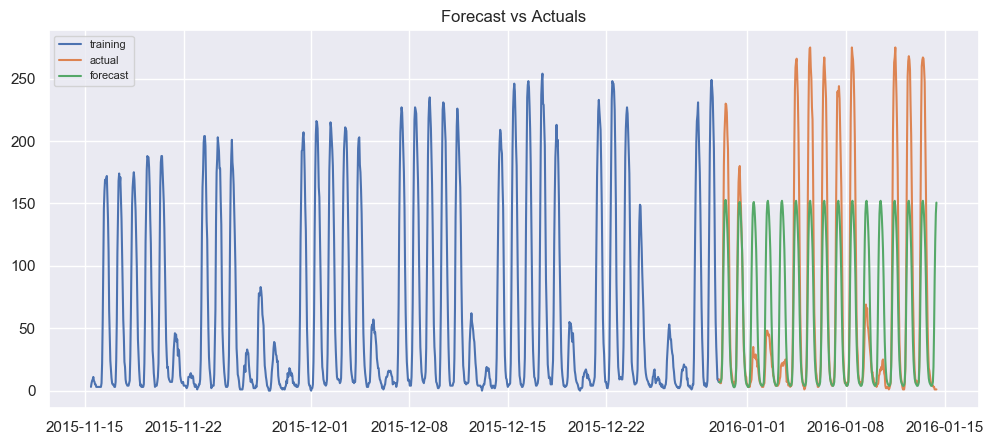

In [176]:
# Build Model
# model = ARIMA(y_train_df, order=(7,0,2))
# model_fit = model.fit(disp=-1)

# Forecast
fc = model_smax_fit.predict(start=test_dates[0], end=test_dates[-1], exog=[[exog_var_test]])  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=dates_test)
lower_series = pd.Series(conf[:, 0], index=dates_test)
upper_series = pd.Series(conf[:, 1], index=dates_test)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train_df, label='training')
plt.plot(y_test_df, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
error = metrics.mean_squared_error(y_test, fc_series.values)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % error**0.5)

plt.show()

## Prophet 

In [128]:
proph_df = df_hourly[['driver_id']].reset_index()
proph_df.columns = ['ds','y']

In [159]:
from fbprophet import Prophet
m=Prophet(
     daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
)

In [160]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.weekday in (6, 0)
proph_df['is_weekend'] = proph_df['ds'].apply(is_weekend)

In [161]:
m.add_seasonality(name='weekend', period=1, fourier_order=5, condition_name='is_weekend')
m.daily_seasonality=True
m.weekly_seasonality=True
m.add_country_holidays(country_name='US')

In [162]:
m.fit(proph_df[proph_df.ds<'2015-12-30'])

/anaconda3/envs/main_py36/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  (dates - pd.datetime(1970, 1, 1))
/anaconda3/envs/main_py36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [163]:
forecast = m.predict(proph_df[proph_df.ds>='2015-12-30'].drop(['y'], axis=1))

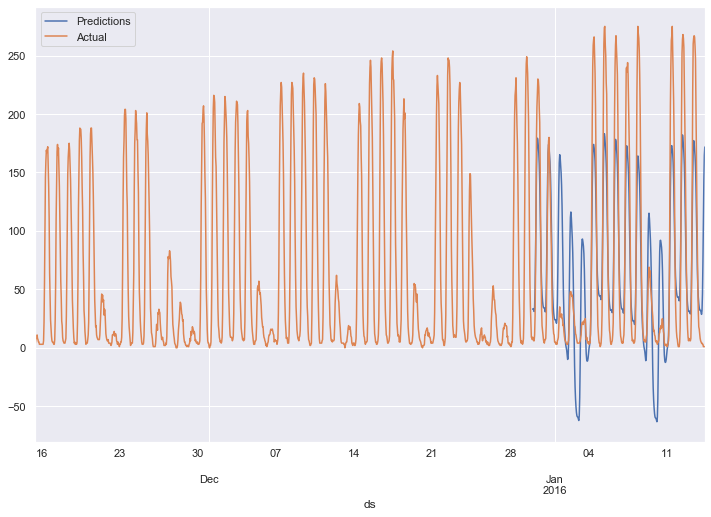

In [164]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
proph_df.plot(x='ds',y='y',label='Actual',legend=True,ax=ax)

/anaconda3/envs/main_py36/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  (dates - pd.datetime(1970, 1, 1))


AttributeError: 'DatetimeIndex' object has no attribute 'weekday_name'

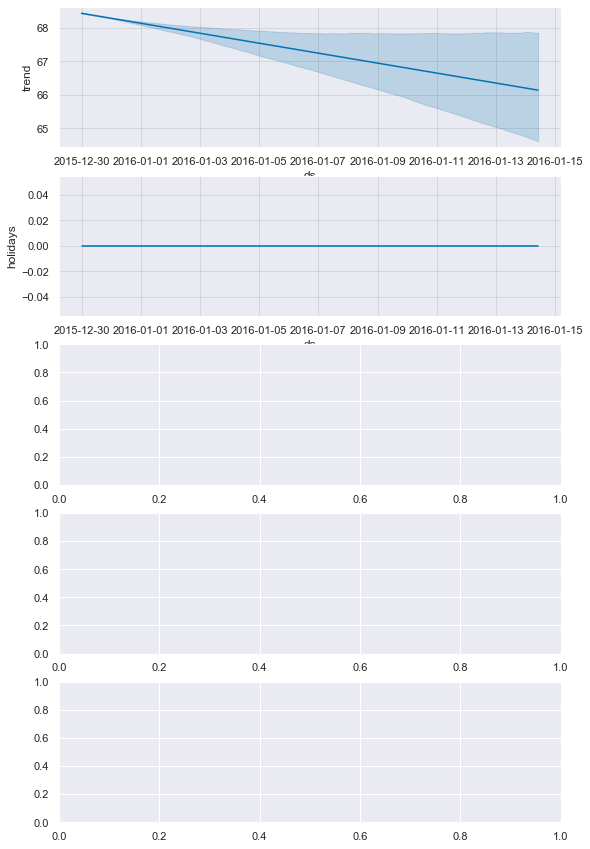

In [184]:
m.plot_components(forecast)

In [167]:
error = metrics.mean_squared_error(y_test, forecast.yhat)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % (error)**0.5)


Test MSE: 2696.387
Test RMSE: 51.927


In [ ]:
model3=Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True)
model3.add_country_holidays(country_name='US')
model3.fit(proph_df[proph_df.ds<'2015-12-30'])
future3 = model3.make_future_dataframe(periods=371,freq="H")
forecast3 = model3.predict(future3)
fig = model3.plot(forecast3)
ax = forecast3.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
proph_df.plot(x='ds',y='y',label='Actual',legend=True,ax=ax)